In [1]:
from keras.models import * 
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
from keras.utils import multi_gpu_model
import tensorflow as tf

Using TensorFlow backend.


In [2]:
input_shape = (299, 299, 3)
nb_classes = 20
nb_gpus = 2

In [3]:
with tf.device('/cpu:0'):
    input_tensor = Input(input_shape)
    x = Lambda(xception.preprocess_input)(input_tensor)

    base_model = Xception(input_tensor=x, weights=None, include_top=False)
    m_out = base_model.output
    p_out = GlobalAveragePooling2D()(m_out)
    p_out = Dropout(0.5)(p_out)
    prediction = Dense(nb_classes, activation='softmax', name="prediction")(p_out)
    model = Model(inputs=base_model.input, outputs=prediction)

if nb_gpus > 1:
    model = multi_gpu_model(model, gpus=nb_gpus)
    model.compile(optimizer='Adadelta', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 299, 299, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 299, 299, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 20)           20902460    lambda_2[0][0]                   
                                                                 lambda_3[0][0]                   
__________

In [4]:
model.load_weights("weights_036_0.1710.hdf5")

In [5]:
batch_size = 64
img_size = (299, 299)
test_path = "/home/nvme/CELLS_hls_299/test"

gen = ImageDataGenerator()
test_generator = gen.flow_from_directory(test_path, 
                                         img_size, 
                                         shuffle=False,
                                         batch_size=batch_size)
nb_tests = test_generator.samples
y_test = test_generator.classes
y_pred = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)

Found 13762 images belonging to 20 classes.
216/216 [==============================] - 52s 239ms/step


In [6]:
print(nb_tests, len(y_test), len(y_pred))
print(y_test.shape, y_test[0])
print(y_pred.shape, y_pred[0])

13762 13762 13762
(13762,) 0
(13762, 20) [1.0000000e+00 9.9294295e-35 2.3082985e-28 1.7557162e-24 7.3799679e-27
 1.6561409e-22 4.2174507e-32 0.0000000e+00 0.0000000e+00 0.0000000e+00
 1.8565885e-29 0.0000000e+00 3.2810065e-19 0.0000000e+00 5.6276551e-35
 1.6175303e-36 1.7703588e-30 4.1148697e-24 1.3296099e-22 6.2678119e-28]


In [7]:
# confusion matrix
import numpy as np
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred.argmax(axis=1))
print(conf_matrix)

[[ 648    0    0    0    0    0    1    0    0    0    0    0    0    0
     0    0    0    1    0    0]
 [   0  370    0    0    1    0    8    3    6    0    0    1    0    0
     0    1    0    0    0    0]
 [   0    0  875    0    0    0    0    0    0    5   22   37    8    0
     0    2    0    0    0    1]
 [   0    0    0 1433    0    0    0    0    0    0    0    0   18    0
     0    0    0    0    0    0]
 [   0    1    0    0   75    0    1    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [   0    0    0    0    0  431    0    0    0    0    0    0    2    0
     0    1    1    1    0    0]
 [   0   20    3    0    0    0  562    9    6    4    0    0    1   13
     5    4    1    1    0    2]
 [   0   17    0    0    1    0    4  537   23    0    0    0    0    3
     0    1    1    0    0    0]
 [   0    4    0    0    0    0    3   15  376    7    0    0    0    2
     0    6    0    0    0    0]
 [   0    0    3    0    0    0    0    0    3 1854    

In [8]:
class_map = test_generator.class_indices
print(class_map)
classes = sorted(class_map.items(), key=lambda kv: kv[1])
print(classes)
classes = [entry[0] for entry in classes]
print(classes)

{'MC': 12, 'SC': 14, 'LSIL_F': 11, 'AGC': 1, 'LSIL_E': 10, 'CC': 3, 'ASCUS': 2, 'HSIL_S': 9, 'FUNGI': 5, 'RC': 13, 'SCC_R': 16, 'EC': 4, 'VIRUS': 19, 'TRASH': 17, 'ACTINO': 0, 'SCC_G': 15, 'GEC': 6, 'TRI': 18, 'HSIL_M': 8, 'HSIL_B': 7}
[('ACTINO', 0), ('AGC', 1), ('ASCUS', 2), ('CC', 3), ('EC', 4), ('FUNGI', 5), ('GEC', 6), ('HSIL_B', 7), ('HSIL_M', 8), ('HSIL_S', 9), ('LSIL_E', 10), ('LSIL_F', 11), ('MC', 12), ('RC', 13), ('SC', 14), ('SCC_G', 15), ('SCC_R', 16), ('TRASH', 17), ('TRI', 18), ('VIRUS', 19)]
['ACTINO', 'AGC', 'ASCUS', 'CC', 'EC', 'FUNGI', 'GEC', 'HSIL_B', 'HSIL_M', 'HSIL_S', 'LSIL_E', 'LSIL_F', 'MC', 'RC', 'SC', 'SCC_G', 'SCC_R', 'TRASH', 'TRI', 'VIRUS']


(13762, 20) [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Text(0, 0.5, 'True Positive Rate')

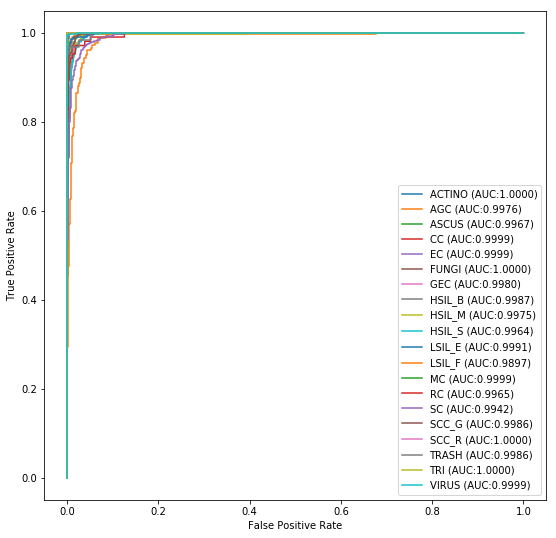

In [9]:
# AUC ROC

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import to_categorical
from sklearn.metrics import roc_curve, auc

# one-hot encode y_test
y_test_ = to_categorical(y_test)
print(y_test_.shape, y_test_[0])

fig, ax = plt.subplots(1,1, figsize = (9, 9))
for i,class_i in enumerate(classes):
    fpr, tpr, thresholds = roc_curve(y_test_[:,i], y_pred[:,i])
    ax.plot(fpr, tpr, label="{0} (AUC:{1:0.4f})".format(class_i, auc(fpr, tpr)))
ax.legend()
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")